# Calibration of the school model based on empirical data

In [1]:
import numpy as np
import pandas as pd
import numpy as np
from os.path import join
import json

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# custom functions to run the calibration simulations
import calibration_functions as cf

# parallelisation functionality
from multiprocess import Pool
import psutil
from tqdm import tqdm

## Empirical observations

In [2]:
empirical_data_src = '../../data/calibration/empirical_observations'

# distribution of outbreak sizes by school type
outbreak_sizes = pd.read_csv(\
            join(empirical_data_src, 'empirical_outbreak_sizes.csv'))
# ratio of infections in the student and teacher groups
group_distributions = pd.read_csv(\
            join(empirical_data_src, 'empirical_group_distributions.csv'))
# ratio of index cases in the student and teacher groups
agent_index_ratios = pd.read_csv(\
            join(empirical_data_src, 'empirical_index_case_ratios.csv'))
agent_index_ratios.index = agent_index_ratios['school_type']
# ratio of symptomatic cases in the student and teacher groups
symptomatic_case_ratios = pd.read_csv(\
            join(empirical_data_src, 'empirical_symptomatic_case_ratios.csv'))

In [3]:
# note: these are the number of clusters per school type from the slightly older
# data version (November 2020). For primary and lower secondary school types,
# the counts are split evenly between schools with and without daycare. 
counts = pd.DataFrame({'type':['primary', 'primary_dc', 
                               'lower_secondary', 'lower_secondary_dc',
                               'upper_secondary', 'secondary'],
                      'count':[33.5, 33.5, 90, 90, 116, 70]})

counts.index = counts['type']
counts = counts.drop(columns=['type'])
# The cluster counts are used to weigh the respective school type in the 
# calibration process.
counts['weight'] = counts['count'] / counts['count'].sum()

## Simulation settings

In [4]:
# List of prevention measures that were in place in schools in the weeks 36-45
# of the year 2020 in Austrian schools. This list was compiled from information
# collected in interviews with teachers of different school types. NOTE: so far
# there are no recorded differences between school types.
with open('params/calibration_measures.json', 'r') as fp:
    prevention_measures = json.load(fp)
# simulation parameters, specifically the
# - base transmission risk (calibrated from household transmissions)
# - subclinical transmission modifier (literature value)
# - exposure duration, time until symtpoms and infection duration (lit. values)
# - age symptom discount (fit to empirical observations)
with open('params/calibration_simulation_parameters.json', 'r') as fp:
    simulation_params = json.load(fp)
# characteristics (# classes, # students / class, # teachers) of the "average" 
# school, depending on school type. These characteristics were determined in 
# interviews with Austrian teachers and from statistics about Austrian schools 
# (year 2017/18, page 10: https://www.bmbwf.gv.at/Themen/schule/schulsystem/gd.html)
# NOTE: "students" indicates the number of students per class
with open('params/calibration_school_characteristics.json', 'r') as fp:
    school_characteristics = json.load(fp)

## Coarse grid search without age dependence

### Create calibration parameter grid

In [5]:
## grid of parameters that need to be calibrated

N_runs = 500

# school types over which the calibration us run
school_types = ['primary', 'primary_dc', 'lower_secondary',
                'lower_secondary_dc', 'upper_secondary', 'secondary']

# the contact weight is the modifier by which the base transmission risk (for
# household transmissions) is multiplied for contacts of type "intermediate" 
# and of type "far"
intermediate_contact_weights_coarse = np.arange(0, 1, 0.05)
far_contact_weights_coarse = np.arange(0, 1, 0.05)

# list of all possible parameter combinations from the grid
# Note: the age transmission discount is set to 0 for all parameter
# combinations here
screening_params_coarse = [(N_runs, i, j, k, 0) for i in school_types \
                    for j in intermediate_contact_weights_coarse \
                    for k in far_contact_weights_coarse if j > k]

print('There are {} parameter combinations to sample.'\
      .format(len(screening_params_coarse)))

There are 1140 parameter combinations to sample.


### Run the sampling

In [6]:
def run(params):
    '''
    Runs an ensemble of simulations and collects observable statistics. To be 
    run in parallel on many workers. Note: I/O paths and the number of runs per 
    ensemble hare hard coded here, because I only want to pass the parameter 
    values that are being screened in the simulation run to the function via the
    parallel processing interface.
    
    Parameters:
    -----------
    param_list : iterable
        Iterable that contains the values for the parameters test_type, 
        index_case, e_screen_range and r_screen_range that are passed to the
        simulation.
        
    Returns:
    --------
    row : dictionary
        Dictionary of the ensemble statistics of the observables.
    '''    

    # extract the simulation parameters from the parameter list
    N_runs, school_type, intermediate_contact_weight, far_contact_weight,\
                age_transmission_discount = params

    # run the ensemble with the given parameter combination and school type
    ensemble_results = cf.run_ensemble(N_runs, school_type,
            intermediate_contact_weight, far_contact_weight, 
            age_transmission_discount, prevention_measures,
            school_characteristics, agent_index_ratios,
            simulation_params, contact_network_src, ensmbl_dst)

    # calculate the difference between the ensemble characteristics
    # (outbreak distribution, ratio of student to teacher cases)
    row = cf.evaluate_ensemble(ensemble_results, school_type,
            intermediate_contact_weight, far_contact_weight,
            age_transmission_discount, outbreak_sizes, group_distributions)
    
    return row

In [10]:
%%time
contact_network_src = '../../data/contact_networks/calibration'
ensmbl_dst = '../../data/calibration/simulation_results/ensembles'

number_of_cores = psutil.cpu_count(logical=True) - 2
pool = Pool(number_of_cores)

rows = []
for row in tqdm(pool.imap_unordered(func=run, iterable=screening_params_coarse),
                total=len(screening_params_coarse)):
        rows.append(row)

# turn off your parallel workers 
pool.close()

# format and dump the results to disk
dst = '../../data/calibration/simulation_results'
results = pd.DataFrame()
for row in rows:
    results = results.append(row, ignore_index=True)
    
results.reset_index()
index_cols = ['school_type', 'intermediate_contact_weight',
              'far_contact_weight', 'age_transmission_discount']
other_cols = [c for c in results.columns if c not in index_cols]
results = results[index_cols + other_cols]

results.to_csv(join(dst,'calibration_results_coarse_sampling_noage_{}.csv'\
                   .format(N_runs)), index=False)
results.head(3)

100%|██████████| 1140/1140 [42:22:22<00:00, 133.81s/it]    


CPU times: user 13.7 s, sys: 2.82 s, total: 16.5 s
Wall time: 1d 18h 22min 25s


,school_type,intermediate_contact_weight,far_contact_weight,age_transmission_discount,chi2_distance_distro,chi2_distance_size,chi2_distance_total,sum_of_squares_distro,sum_of_squares_size,sum_of_squares_total
0,primary,0.15,0.10,0.0,0.060263,0.210431,0.270695,0.088963,0.267885,0.356848
1,primary,0.25,0.15,0.0,0.067555,0.072562,0.140117,0.099727,0.091221,0.190948
2,primary,0.20,0.10,0.0,0.072661,0.152732,0.225393,0.107265,0.194364,0.301629


### Analyze the coarse sampling

#### Aggregate results

In [7]:
# load the collected ensemble statistics
dst = '../../data/calibration/simulation_results'
N = 500
results_coarse = pd.read_csv(join(dst, 'calibration_results_coarse_sampling_noage_{}.csv'\
                        .format(N)))
results_coarse['intermediate_contact_weight'] = results_coarse['intermediate_contact_weight'].round(2)
results_coarse['far_contact_weight'] = results_coarse['far_contact_weight'].round(2)
results_coarse.head(3)

,school_type,intermediate_contact_weight,far_contact_weight,age_transmission_discount,chi2_distance_distro,chi2_distance_size,chi2_distance_total,sum_of_squares_distro,sum_of_squares_size,sum_of_squares_total
0,primary,0.15,0.10,0.0,0.060263,0.210431,0.270695,0.088963,0.267885,0.356848
1,primary,0.25,0.15,0.0,0.067555,0.072562,0.140117,0.099727,0.091221,0.190948
2,primary,0.20,0.10,0.0,0.072661,0.152732,0.225393,0.107265,0.194364,0.301629


In [8]:
results_coarse['chi2_distance_total_weighted'] = results_coarse['chi2_distance_total']
for i, row in results_coarse.iterrows():
    st = row['school_type']
    weight = counts.loc[st, 'weight']
    error = row['chi2_distance_total']
    results_coarse.loc[i, 'chi2_distance_total_weighted'] = error * weight

In [9]:
# since we calibrate the intermediate_contact_weight, far_contact_weight and 
# age_transmission_discount over all school types together, we have to find
# the parameter combination that minimizes the sum of errors over all school
# types. 
agg_results_coarse = results_coarse.groupby(['intermediate_contact_weight',
                               'far_contact_weight']).sum()

opt_coarse = agg_results_coarse.loc[\
        agg_results_coarse['chi2_distance_total_weighted'].idxmin()].name
opt_intermediate_contact_weight_coarse = opt_coarse[0]
opt_far_contact_weight_coarse = opt_coarse[1]

print('optimal random sampling parameter combination:')
print('\t intermediate contact weight: {:1.3f}'\
      .format(opt_intermediate_contact_weight_coarse))
print('\t far contact weight: {:1.3f}'\
      .format(opt_far_contact_weight_coarse))

optimal random sampling parameter combination:
	 intermediate contact weight: 0.300
	 far contact weight: 0.250


In [10]:
img_coarse = np.zeros((len(intermediate_contact_weights_coarse),
                len(far_contact_weights_coarse)))
for i, intermediate in enumerate(intermediate_contact_weights_coarse):
    for j, far in enumerate(far_contact_weights_coarse):
        intermediate = round(intermediate, 2)
        far = round(far, 2)
        try:
            img_coarse[i, j] = agg_results_coarse\
                .loc[intermediate, far]['chi2_distance_total_weighted']
        except KeyError:
            img_coarse[i, j] = np.nan

#### Plot

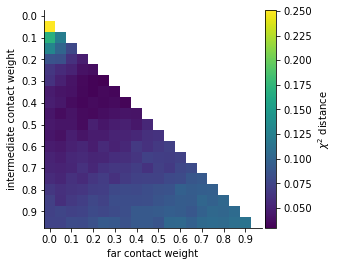

In [11]:
fig, ax = plt.subplots()
im = ax.imshow(img_coarse)
ax.set_yticks(range(len(intermediate_contact_weights_coarse))[::2])
ax.set_yticklabels(['{:1.1f}'.format(icw) for \
                    icw in intermediate_contact_weights_coarse[::2]])
ax.set_xticks(range(len(far_contact_weights_coarse))[::2])
ax.set_xticklabels(['{:1.1f}'.format(fcw) for \
                    fcw in far_contact_weights_coarse[::2]])

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cbar.set_label('$\chi^2$ distance')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_ylabel('intermediate contact weight')
ax.set_xlabel('far contact weight');

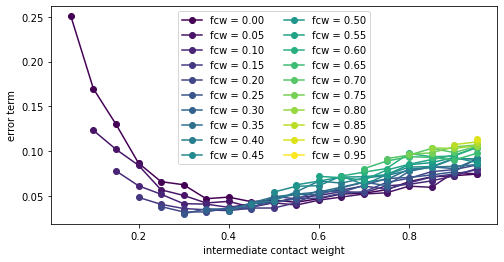

In [12]:
agg_results_selection_coarse = agg_results_coarse.copy().reset_index()

fig, ax = plt.subplots(figsize=(8,4))
cmap = plt.get_cmap('viridis')

for i, far_level in enumerate(far_contact_weights_coarse):
    far_level = round(far_level, 2)
    agg_results_level = agg_results_selection_coarse[\
        agg_results_selection_coarse['far_contact_weight'] == far_level]\
        .reset_index(drop=True)
    
    ax.plot(agg_results_level['intermediate_contact_weight'],
            agg_results_level['chi2_distance_total_weighted'],
            'o-', color=cmap(i/(len(far_contact_weights_coarse) - 1)),
            label='fcw = {:1.2f}'.format(far_level))
    
ax.set_ylabel('error term')
ax.set_xlabel('intermediate contact weight')
ax.legend(ncol=2, loc=0);

## Large ensemble grid search without age dependence

### Create calibration parameter grid

In [13]:
print('optimal random sampling parameter combination:')
print('\t intermediate contact weight: {:1.3f}'\
      .format(opt_intermediate_contact_weight_coarse))
print('\t far contact weight: {:1.3f}'\
      .format(opt_far_contact_weight_coarse))

optimal random sampling parameter combination:
	 intermediate contact weight: 0.300
	 far contact weight: 0.250


In [14]:
## grid of parameters that need to be calibrated
N_runs = 2000

# school types over which the calibration us run
school_types = ['primary', 'primary_dc', 'lower_secondary',
                'lower_secondary_dc', 'upper_secondary', 'secondary']

# the contact weight is the modifier by which the base transmission risk (for
# household transmissions) is multiplied for contacts of type "intermediate" 
# and of type "far". Parameter values are chosen around the optimum from the
# previous random sampling search
intermediate_contact_weights_large_ensmbl = np.hstack([
    np.arange(opt_intermediate_contact_weight_coarse - 0.1, 
              opt_intermediate_contact_weight_coarse, 0.05),
    np.arange(opt_intermediate_contact_weight_coarse, 
              opt_intermediate_contact_weight_coarse + 0.21, 0.05)
    ])

far_contact_weights_large_ensmbl = np.hstack([
    np.arange(opt_far_contact_weight_coarse - 0.2, 
              opt_far_contact_weight_coarse, 0.05),
    np.arange(opt_far_contact_weight_coarse, 
              opt_far_contact_weight_coarse + 0.21, 0.05)
    ])
print('intermediate: ', intermediate_contact_weights_large_ensmbl)
print('far: ', far_contact_weights_large_ensmbl)

# list of all possible parameter combinations from the grid
# Note: the age transmission discount is set to 0 for all parameter
# combinations here
screening_params_large_ensmbl = [(N_runs, i, j, k, 0) for i in school_types \
                    for j in intermediate_contact_weights_large_ensmbl \
                    for k in far_contact_weights_large_ensmbl if j > k]

print('There are {} parameter combinations to sample.'\
      .format(len(screening_params_large_ensmbl)))

intermediate:  [0.2  0.25 0.3  0.35 0.4  0.45 0.5 ]
far:  [0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45]
There are 252 parameter combinations to sample.


### Run the sampling

In [18]:
%%time
contact_network_src = '../../data/contact_networks/calibration'
ensmbl_dst = '../../data/calibration/simulation_results/ensembles_fine'

number_of_cores = psutil.cpu_count(logical=True) - 3
pool = Pool(number_of_cores)

rows = []
for row in tqdm(pool.imap_unordered(func=run, iterable=screening_params_large_ensmbl),
                total=len(screening_params_large_ensmbl)):
        rows.append(row)

# turn off your parallel workers 
pool.close()

# format and dump the results to disk
dst = '../../data/calibration/simulation_results'
results = pd.DataFrame()
for row in rows:
    results = results.append(row, ignore_index=True)
    
results.reset_index()
index_cols = ['school_type', 'intermediate_contact_weight',
              'far_contact_weight', 'age_transmission_discount']
other_cols = [c for c in results.columns if c not in index_cols]
results = results[index_cols + other_cols]

results.to_csv(join(dst,'calibration_results_fine_sampling_noage_{}.csv'\
                   .format(N_runs)), index=False)
results.head(3)

100%|██████████| 42/42 [17:19:23<00:00, 1484.85s/it]   

CPU times: user 2.92 s, sys: 982 ms, total: 3.91 s
Wall time: 17h 19min 23s


,school_type,intermediate_contact_weight,far_contact_weight,age_transmission_discount,chi2_distance_distro,chi2_distance_size,chi2_distance_total,sum_of_squares_distro,sum_of_squares_size,sum_of_squares_total
0,secondary,0.25,0.05,0.0,0.000403,0.055579,0.055983,0.000566,0.064428,0.064994
1,secondary,0.20,0.05,0.0,0.000444,0.084991,0.085435,0.000623,0.100282,0.100905
2,secondary,0.20,0.10,0.0,0.000022,0.067139,0.067161,0.000031,0.078558,0.078589


### Analyze the large ensemble grid search

#### Collect ensemble results

In [26]:
# do not run again, the first 10 ensembles of secondary schools have been
# overwritten by test-ensembles :/ 
# correct results are saved in calibration_results_coarse_sampling_noage_2000.csv
'''
src = '../../data/calibration/simulation_results/ensembles_large'
dst = '../../data/calibration/simulation_results'
N_runs = 2000

results_large_ensmbl = pd.DataFrame()
for i, ep in enumerate(screening_params_large_ensmbl):
    print('{}/{}'.format(i, len(screening_params_large_ensmbl)))
    row = cf.evaulate_from_ensemble_data(src, ep, outbreak_sizes,
                                      group_distributions)
    
    results_large_ensmbl = results_large_ensmbl.append(row, ignore_index=True)
    
index_cols = ['school_type', 'intermediate_contact_weight',
              'far_contact_weight', 'age_transmission_discount']
other_cols = [c for c in results_large_ensmbl.columns if c not in index_cols]
results_large_ensmbl = results_large_ensmbl[index_cols + other_cols]

results_large_ensmbl.to_csv(join(dst,'calibration_results_coarse_sampling_noage_{}.csv'\
                   .format(N_runs)), index=False)
'''


0/252
1/252
2/252
3/252
4/252
5/252
6/252
7/252
8/252
9/252
10/252
11/252
12/252
13/252
14/252
15/252
16/252
17/252
18/252
19/252
20/252
21/252
22/252
23/252
24/252
25/252
26/252
27/252
28/252
29/252
30/252
31/252
32/252
33/252
34/252
35/252
36/252
37/252
38/252
39/252
40/252
41/252
42/252
43/252
44/252
45/252
46/252
47/252
48/252
49/252
50/252
51/252
52/252
53/252
54/252
55/252
56/252
57/252
58/252
59/252
60/252
61/252
62/252
63/252
64/252
65/252
66/252
67/252
68/252
69/252
70/252
71/252
72/252
73/252
74/252
75/252
76/252
77/252
78/252
79/252
80/252
81/252
82/252
83/252
84/252
85/252
86/252
87/252
88/252
89/252
90/252
91/252
92/252
93/252
94/252
95/252
96/252
97/252
98/252
99/252
100/252
101/252
102/252
103/252
104/252
105/252
106/252
107/252
108/252
109/252
110/252
111/252
112/252
113/252
114/252
115/252
116/252
117/252
118/252
119/252
120/252
121/252
122/252
123/252
124/252
125/252
126/252
127/252
128/252
129/252
130/252
131/252
132/252
133/252
134/252
135/252
136/252
137/252
138/25

In [15]:
# load the collected ensemble statistics
dst = '../../data/calibration/simulation_results'
N_runs = 2000
results_large_ensmbl = pd.read_csv(\
    join(dst, 'calibration_results_coarse_sampling_noage_{}.csv'.format(N_runs)))
results_large_ensmbl['intermediate_contact_weight'] = results_large_ensmbl['intermediate_contact_weight'].round(2)
results_large_ensmbl['far_contact_weight'] = results_large_ensmbl['far_contact_weight'].round(2)
results_large_ensmbl.head(3)

,school_type,intermediate_contact_weight,far_contact_weight,age_transmission_discount,chi2_distance_distro,chi2_distance_size,chi2_distance_total,sum_of_squares_distro,sum_of_squares_size,sum_of_squares_total
0,primary,0.2,0.05,0.0,0.094066,0.147311,0.241377,0.138863,0.186966,0.325829
1,primary,0.2,0.10,0.0,0.078043,0.127824,0.205867,0.115209,0.162334,0.277543
2,primary,0.2,0.15,0.0,0.064344,0.119786,0.184130,0.094987,0.152387,0.247374


#### Aggregate results

In [16]:
results_large_ensmbl['chi2_distance_total_weighted'] = results_large_ensmbl['chi2_distance_total']
for i, row in results_large_ensmbl.iterrows():
    st = row['school_type']
    weight = counts.loc[st, 'weight']
    error = row['chi2_distance_total']
    results_large_ensmbl.loc[i, 'chi2_distance_total_weighted'] = error * weight

In [17]:
agg_results_large_ensmbl = results_large_ensmbl.groupby(['intermediate_contact_weight',
                 'far_contact_weight']).sum()
opt_large_ensembl = agg_results_large_ensmbl.loc[\
        agg_results_large_ensmbl['chi2_distance_total_weighted'].idxmin()].name
opt_intermediate_contact_weight_large_ensembl = opt_large_ensembl[0]
opt_far_contact_weight_large_ensmbl = opt_large_ensembl[1]

print('optimal grid search parameter combination:')
print('\t intermediate contact weight: {:1.3f}'\
      .format(opt_intermediate_contact_weight_large_ensembl))
print('\t far contact weight: {:1.3f}'\
      .format(opt_far_contact_weight_large_ensmbl))

optimal grid search parameter combination:
	 intermediate contact weight: 0.300
	 far contact weight: 0.250


In [18]:
img_large_ensmbl = np.zeros((len(intermediate_contact_weights_large_ensmbl),
                len(far_contact_weights_large_ensmbl)))
for i, intermediate in enumerate(intermediate_contact_weights_large_ensmbl):
    for j, far in enumerate(far_contact_weights_large_ensmbl):
        intermediate = round(intermediate, 2)
        far = round(far, 2)
        try:
            img_large_ensmbl[i, j] = agg_results_large_ensmbl\
                .loc[intermediate, far]['chi2_distance_total_weighted']
        except KeyError:
            img_large_ensmbl[i, j] = np.nan

#### Plot

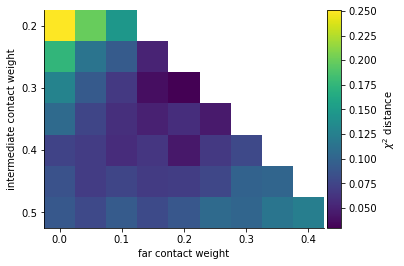

In [19]:
fig, ax = plt.subplots(figsize=(6, 4))

im1 = ax.imshow(img_large_ensmbl)
ax.set_yticks(range(len(intermediate_contact_weights_large_ensmbl))[::2])
ax.set_yticklabels(['{:1.1f}'.format(icw) for \
                    icw in intermediate_contact_weights_large_ensmbl[::2]])
ax.set_xticks(range(len(far_contact_weights_large_ensmbl))[::2])
ax.set_xticklabels(['{:1.1f}'.format(fcw) for \
                    fcw in far_contact_weights_large_ensmbl[::2]])

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cbar.set_label('$\chi^2$ distance')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_ylabel('intermediate contact weight')
ax.set_xlabel('far contact weight');

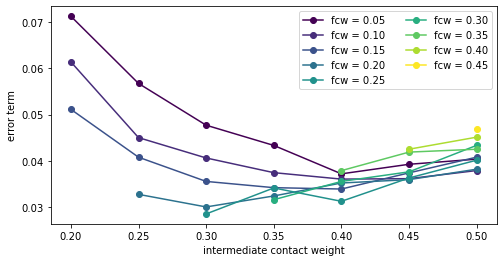

In [20]:
agg_results_selection_large_ensmbl = agg_results_large_ensmbl.copy().reset_index()

fig, ax = plt.subplots(figsize=(8,4))
cmap = plt.get_cmap('viridis')

for i, far_level in enumerate(far_contact_weights_large_ensmbl):
    far_level = round(far_level, 2)
    agg_results_level = agg_results_selection_large_ensmbl[\
        agg_results_selection_large_ensmbl['far_contact_weight'] == far_level]\
        .reset_index(drop=True)
    
    ax.plot(agg_results_level['intermediate_contact_weight'],
            agg_results_level['chi2_distance_total_weighted'],
            'o-', color=cmap(i/(len(far_contact_weights_large_ensmbl) - 1)),
            label='fcw = {:1.2f}'.format(far_level))
    
ax.set_ylabel('error term')
ax.set_xlabel('intermediate contact weight')
ax.legend(ncol=2, loc=0);

## Fine grid search without age dependence

### Create calibration parameter grid

In [21]:
print('optimal random sampling parameter combination:')
print('\t intermediate contact weight: {:1.3f}'\
      .format(opt_intermediate_contact_weight_coarse))
print('\t far contact weight: {:1.3f}'\
      .format(opt_far_contact_weight_coarse))

optimal random sampling parameter combination:
	 intermediate contact weight: 0.300
	 far contact weight: 0.250


In [220]:
## grid of parameters that need to be calibrated
N_runs = 2000

# school types over which the calibration us run
school_types = ['primary', 'primary_dc', 'lower_secondary',
                'lower_secondary_dc', 'upper_secondary', 'secondary']

# the contact weight is the modifier by which the base transmission risk (for
# household transmissions) is multiplied for contacts of type "intermediate" 
# and of type "far". Parameter values are chosen around the optimum from the
# previous random sampling search
intermediate_contact_weights_fine = np.hstack([
    np.arange(opt_intermediate_contact_weight_coarse - 0.05, 
              opt_intermediate_contact_weight_coarse, 0.02),
    np.arange(opt_intermediate_contact_weight_coarse, 
              opt_intermediate_contact_weight_coarse + 0.27, 0.02)
    ])

far_contact_weights_fine = np.hstack([
    np.arange(opt_far_contact_weight_coarse - 0.15, 
              opt_far_contact_weight_coarse, 0.02),
    np.arange(opt_far_contact_weight_coarse, 
              opt_far_contact_weight_coarse + 0.11, 0.02)
    ])
print('intermediate: ', intermediate_contact_weights_fine)
print('far: ', far_contact_weights_fine)

# list of all possible parameter combinations from the grid
# Note: the age transmission discount is set to 0 for all parameter
# combinations here
screening_params = [(N_runs, i, j, k, 0) for i in school_types \
                    for j in intermediate_contact_weights_fine \
                    for k in far_contact_weights_fine]

print('There are {} parameter combinations to sample.'.format(len(screening_params)))

intermediate:  [0.25 0.27 0.29 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.5
 0.52 0.54 0.56]
far:  [0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.25 0.27 0.29 0.31 0.33 0.35]
There are 1428 parameter combinations to sample.


In [243]:
existing_params = {(round(row['intermediate_contact_weight'], 2),
                    round(row['far_contact_weight'], 2)) \
                   for i, row in results_fine.iterrows()}

wanted_params = {(round(icw, 2), round(fcw, 2)) for icw in intermediate_contact_weights_fine \
                            for fcw in far_contact_weights_fine}

missing_params = wanted_params.difference(existing_params)

missing_params = np.asarray([[mp[0], mp[1]] for mp in missing_params])
np.savetxt('missing_params.txt', missing_params, fmt='%.2f')

### Run the sampling

In [18]:
%%time
contact_network_src = '../../data/contact_networks/calibration'
ensmbl_dst = '../../data/calibration/simulation_results/ensembles_fine'

number_of_cores = psutil.cpu_count(logical=True) - 3
pool = Pool(number_of_cores)

rows = []
for row in tqdm(pool.imap_unordered(func=run, iterable=screening_params),
                total=len(screening_params)):
        rows.append(row)

# turn off your parallel workers 
pool.close()

# format and dump the results to disk
dst = '../../data/calibration/simulation_results'
results = pd.DataFrame()
for row in rows:
    results = results.append(row, ignore_index=True)
    
results.reset_index()
index_cols = ['school_type', 'intermediate_contact_weight',
              'far_contact_weight', 'age_transmission_discount']
other_cols = [c for c in results.columns if c not in index_cols]
results = results[index_cols + other_cols]

results.to_csv(join(dst,'calibration_results_fine_sampling_noage_{}.csv'\
                   .format(N_runs)), index=False)
results.head(3)

100%|██████████| 42/42 [17:19:23<00:00, 1484.85s/it]   

CPU times: user 2.92 s, sys: 982 ms, total: 3.91 s
Wall time: 17h 19min 23s


,school_type,intermediate_contact_weight,far_contact_weight,age_transmission_discount,chi2_distance_distro,chi2_distance_size,chi2_distance_total,sum_of_squares_distro,sum_of_squares_size,sum_of_squares_total
0,secondary,0.25,0.05,0.0,0.000403,0.055579,0.055983,0.000566,0.064428,0.064994
1,secondary,0.20,0.05,0.0,0.000444,0.084991,0.085435,0.000623,0.100282,0.100905
2,secondary,0.20,0.10,0.0,0.000022,0.067139,0.067161,0.000031,0.078558,0.078589


### Analyze the fine grid search

#### Collect results

In [270]:
dst = '../../data/calibration/simulation_results'
N = 2000
results_fine = pd.DataFrame()
for st in school_types:
    tmp1 = pd.read_csv(join(dst, 'calibration_results_fine_sampling_noage_{}_{}.csv')\
                     .format(N, st))
    tmp2 = pd.read_csv(join(dst, 'calibration_results_fine_sampling_noage_{}_{}_combined.csv')\
                     .format(N, st))
    
    tmp = pd.concat([tmp2, tmp1])
    results_fine = pd.concat([results_fine, tmp])
    
results_fine.to_csv(join(dst, 'calibration_results_fine_sampling_noage_{}.csv'\
                        .format(N)), index=False)

In [50]:
dst = '../../data/calibration/simulation_results'
N = 2000
results_fine = pd.DataFrame()
for st in school_types:
    tmp = pd.read_csv(join(dst, 'calibration_results_fine_sampling_noage_{}_{}.csv')\
                     .format(N, st))
    results_fine = pd.concat([results_fine, tmp])
    
results_fine.to_csv(join(dst, 'calibration_results_fine_sampling_noage_{}_part1.csv'\
                        .format(N)), index=False)

#### Aggregate results

In [271]:
N=2000
results_fine = pd.read_csv(join(dst, 'calibration_results_fine_sampling_noage_{}.csv'\
                        .format(N)))
intermediate_contact_weights_fine = \
        list(results_fine['intermediate_contact_weight'].unique())
intermediate_contact_weights_fine.sort()
intermediate_contact_weights_fine = np.asarray(intermediate_contact_weights_fine)

far_contact_weights_fine = \
        list(results_fine['far_contact_weight'].unique())
far_contact_weights_fine.sort()
far_contact_weights_fine = np.asarray(far_contact_weights_fine)

In [272]:
results_fine['intermediate_contact_weight'] = \
    results_fine['intermediate_contact_weight'].apply(lambda x: round(x, 2))
results_fine['far_contact_weight'] = \
    results_fine['far_contact_weight'].apply(lambda x: round(x, 2))

In [273]:
results_fine['chi2_distance_total_weighted'] = results_fine['chi2_distance_total']
for i, row in results_fine.iterrows():
    st = row['school_type']
    weight = counts.loc[st, 'weight']
    error = row['chi2_distance_total']
    results_fine.loc[i, 'chi2_distance_total_weighted'] = error * weight

In [274]:
agg_results_fine = results_fine.groupby(['intermediate_contact_weight',
                 'far_contact_weight']).sum()
opt_fine = agg_results_fine.loc[\
        agg_results_fine['chi2_distance_total_weighted'].idxmin()].name
opt_intermediate_contact_weight_fine = opt_fine[0]
opt_far_contact_weight_fine = opt_fine[1]

print('optimal grid search parameter combination:')
print('\t intermediate contact weight: {:1.3f}'\
      .format(opt_intermediate_contact_weight_fine))
print('\t far contact weight: {:1.3f}'\
      .format(opt_far_contact_weight_fine))

optimal grid search parameter combination:
	 intermediate contact weight: 0.270
	 far contact weight: 0.350


In [275]:
img_fine = np.zeros((len(intermediate_contact_weights_fine),
                len(far_contact_weights_fine)))
for i, intermediate in enumerate(intermediate_contact_weights_fine):
    for j, far in enumerate(far_contact_weights_fine):
        intermediate = round(intermediate, 2)
        far = round(far, 2)
        try:
            img_fine[i, j] = agg_results_fine\
                .loc[intermediate, far]['chi2_distance_total_weighted']
        except KeyError:
            if intermediate >= far:
                print(intermediate, far)
            img_fine[i, j] = np.nan

0.47 0.31
0.47 0.33
0.47 0.35
0.49 0.31
0.49 0.33
0.49 0.35
0.51 0.31
0.51 0.33
0.51 0.35
0.53 0.31
0.53 0.33
0.53 0.35
0.55 0.31
0.55 0.33
0.55 0.35
0.57 0.31
0.57 0.33
0.57 0.35


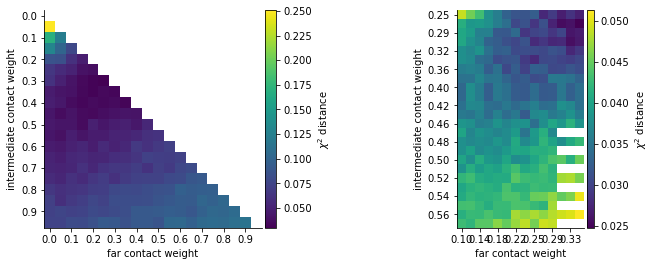

In [276]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ax = axes[0]
im1 = ax.imshow(img_coarse)
ax.set_yticks(range(len(intermediate_contact_weights_coarse))[::2])
ax.set_yticklabels(['{:1.1f}'.format(icw) for \
                    icw in intermediate_contact_weights_coarse[::2]])
ax.set_xticks(range(len(far_contact_weights_coarse))[::2])
ax.set_xticklabels(['{:1.1f}'.format(fcw) for \
                    fcw in far_contact_weights_coarse[::2]])

ax = axes[1]
im2 = ax.imshow(img_fine)
ax.set_yticks(range(len(intermediate_contact_weights_fine))[::2])
ax.set_yticklabels(['{:1.2f}'.format(icw) for \
                    icw in intermediate_contact_weights_fine[::2]])
ax.set_xticks(range(len(far_contact_weights_fine))[::2])
ax.set_xticklabels(['{:1.2f}'.format(fcw) for \
                    fcw in far_contact_weights_fine[::2]])

for ax, im in zip(axes, [im1, im2]):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(im, cax=cax, orientation='vertical')
    cbar.set_label('$\chi^2$ distance')

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.set_ylabel('intermediate contact weight')
    ax.set_xlabel('far contact weight');

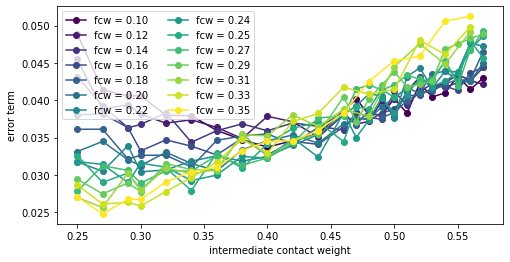

In [277]:
agg_results_selection_fine = agg_results_fine.copy().reset_index()

fig, ax = plt.subplots(figsize=(8,4))
cmap = plt.get_cmap('viridis')

for i, far_level in enumerate(far_contact_weights_fine):
    far_level = round(far_level, 2)
    agg_results_level = agg_results_selection_fine[\
        agg_results_selection_fine['far_contact_weight'] == far_level]\
        .reset_index(drop=True)
    
    ax.plot(agg_results_level['intermediate_contact_weight'],
            agg_results_level['chi2_distance_total_weighted'],
            'o-', color=cmap(i/(len(far_contact_weights_fine) - 1)),
            label='fcw = {:1.2f}'.format(far_level))
    
ax.set_ylabel('error term')
ax.set_xlabel('intermediate contact weight')
ax.legend(ncol=2, loc=0);

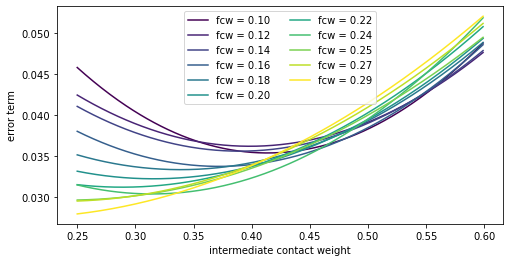

In [125]:
from scipy.optimize import curve_fit

def parabola(x, a, b, c):
    return a * x **2 + b * x + c

agg_results_selection_fine = agg_results_fine.copy().reset_index()

fig, ax = plt.subplots(figsize=(8,4))
cmap = plt.get_cmap('viridis')

for i, far_level in enumerate(far_contact_weights_fine):
    far_level = round(far_level, 2)
    agg_results_level = agg_results_selection_fine[\
        agg_results_selection_fine['far_contact_weight'] == far_level]\
        .reset_index(drop=True)
    
    p0 = [agg_results_level['chi2_distance_total_weighted'].min()]
    
    popt, pcov = curve_fit(parabola, 
                           agg_results_level['intermediate_contact_weight'],
                           agg_results_level['chi2_distance_total_weighted'])
    
    a, b, c = popt
    x = np.arange(0.25, 0.60, 0.001)
    
    ax.plot(x, parabola(x, a, b, c),
            color=cmap(i/(len(far_contact_weights_fine) - 1)),
            label='fcw = {:1.2f}'.format(far_level))
    
    #ax.plot(agg_results_level['intermediate_contact_weight'],
    #        agg_results_level['chi2_distance_total_weighted'],
    #        'o-', color=cmap(i/(len(far_contact_weights_fine) - 1)),
    #        label='fcw = {:1.2f}'.format(far_level))
    
    #ax.plot(agg_results_level['intermediate_contact_weight'],
    #        parabola(agg_results_level['intermediate_contact_weight'], 0.01, 0.1, 0.03))
    
ax.set_ylabel('error term')
ax.set_xlabel('intermediate contact weight')
ax.legend(ncol=2, loc=0);

In [133]:
agg_results_fine

age_transmission_discount  \
intermediate_contact_weight far_contact_weight                              
0.25                        0.10                                      0.0   
                            0.12                                      0.0   
                            0.14                                      0.0   
                            0.16                                      0.0   
                            0.18                                      0.0   
...                                                                   ...   
0.57                        0.22                                      0.0   
                            0.24                                      0.0   
                            0.25                                      0.0   
                            0.27                                      0.0   
                            0.29                                      0.0   

                                                chi2_distance_distro  \
intermediate_contact_weight far_contact_weight                         
0.25                        0.10                            0.188661   
                            0.12                            0.189016   
                            0.14                            0.177137   
                            0.16                            0.156730   
                            0.18                            0.159661   
...                                                              ...   
0.57                        0.22                            0.164294   
                            0.24                            0.167920   
                            0.25                            0.165277   
                            0.27                            0.160581   
                            0.29                            0.162008   

                                                chi2_distance_size  \
intermediate_contact_weight far_contact_weight                       
0.25                        0.10                          0.286199   
                            0.12                          0.247709   
                            0.14                          0.240923   
                            0.16                          0.201248   
                            0.18                          0.190119   
...                                                            ...   
0.57                        0.22                          0.157148   
                            0.24                          0.160996   
                            0.25                          0.147990   
                            0.27                          0.165642   
                            0.29                          0.165267   

                                                chi2_distance_total  \
intermediate_contact_weight far_contact_weight                        
0.25                        0.10                           0.474860   
                            0.12                           0.436725   
                            0.14                           0.418061   
                            0.16                           0.357978   
                            0.18                           0.349780   
...                                                             ...   
0.57                        0.22                           0.321442   
                            0.24                           0.328916   
                            0.25                           0.313267   
                            0.27                           0.326223   
                            0.29                           0.327275   

                                                sum_of_squares_distro  \
intermediate_contact_weight far_contact_weight                          
0.25                        0.10                             0.277584   
                            0.12                       

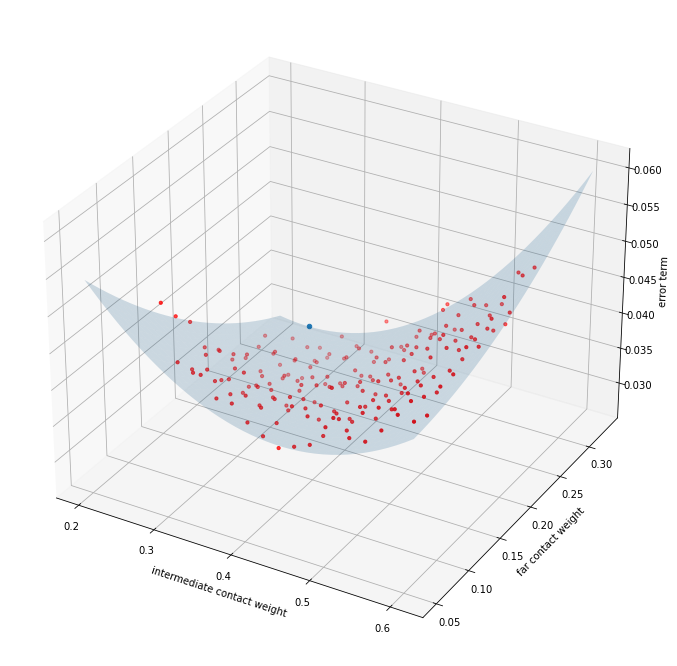

In [214]:
data = agg_results_fine[['chi2_distance_total_weighted']].reset_index().values

# regular grid covering the domain of the data
X,Y = np.meshgrid(np.arange(data[0:,0].min() - 0.05, data[0:,0].max() + 0.05, 0.01),
                  np.arange(data[0:,1].min() - 0.05, data[0:,1].max() + 0.05, 0.01))
XX = X.flatten()
YY = Y.flatten()

A = np.c_[np.ones(data.shape[0]), data[:,:2], np.prod(data[:,:2], axis=1), data[:,:2]**2]
C,_,_,_ = scipy.linalg.lstsq(A, data[:,2])
    
# evaluate it on a grid
Z = np.dot(np.c_[np.ones(XX.shape), XX, YY, XX*YY, XX**2, YY**2], C).reshape(X.shape)

# plot points and fitted surface
fig = plt.figure(figsize=(12, 12))
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, alpha=0.2)
ax.scatter(data[:,0], data[:,1], data[:,2], c='r', s=10)

intermediate_opt, far_opt = np.unravel_index(Z.argmin(), Z.shape)
intermediate_range = np.arange(data[0:,0].min() - 0.05, data[0:,0].max() + 0.05, 0.01)
far_range = np.arange(data[0:,1].min() - 0.05, data[0:,1].max() + 0.05, 0.01)

#ax.scatter([intermediate_range[intermediate_opt]], [far_range[far_opt]],
#           [Z.min()], c='b', s=30)
#ax.scatter(data[0, 0], data[0, 1], data[0, 2], c='b', s=30)
ax.scatter(XX[np.argmin(Z)], YY[np.argmin(Z)], Z.min())

plt.xlabel('intermediate contact weight')
plt.ylabel('far contact weight')
ax.set_zlabel('error term')
#ax.axis('equal')
#ax.axis('tight')
plt.show()

In [215]:
XX[np.argmin(Z)]

0.24000000000000005

In [216]:
YY[np.argmin(Z)]

0.33

In [198]:
far_range[far_opt]

0.09000000000000001

In [195]:
intermediate_range[intermediate_opt]

0.48000000000000026

In [190]:
intermediate_range[intermediate_opt]

0.48000000000000026

In [191]:
far_range[far_opt]

0.09000000000000001

In [201]:
far_opt

4

In [200]:
Z.shape

(29, 42)

In [203]:
Z.min()

0.027343680788068366

In [202]:
Z[intermediate_opt, far_opt]

0.027343680788068366

In [183]:
agg_results_fine['chi2_distance_total_weighted'].min()

0.027754720750935935

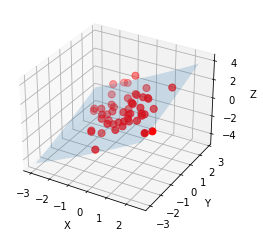

In [143]:
import numpy as np
import scipy.linalg
from mpl_toolkits.mplot3d import Axes3D

# some 3-dim points
mean = np.array([0.0,0.0,0.0])
cov = np.array([[1.0,-0.5,0.8], [-0.5,1.1,0.0], [0.8,0.0,1.0]])
data = np.random.multivariate_normal(mean, cov, 50)

# regular grid covering the domain of the data
X,Y = np.meshgrid(np.arange(-3.0, 3.0, 0.5), np.arange(-3.0, 3.0, 0.5))
XX = X.flatten()
YY = Y.flatten()

order = 2    # 1: linear, 2: quadratic
if order == 1:
    # best-fit linear plane
    A = np.c_[data[:,0], data[:,1], np.ones(data.shape[0])]
    C,_,_,_ = scipy.linalg.lstsq(A, data[:,2])    # coefficients
    
    # evaluate it on grid
    Z = C[0]*X + C[1]*Y + C[2]
    
    # or expressed using matrix/vector product
    #Z = np.dot(np.c_[XX, YY, np.ones(XX.shape)], C).reshape(X.shape)

elif order == 2:
    # best-fit quadratic curve
    A = np.c_[np.ones(data.shape[0]), data[:,:2], np.prod(data[:,:2], axis=1), data[:,:2]**2]
    C,_,_,_ = scipy.linalg.lstsq(A, data[:,2])
    
    # evaluate it on a grid
    Z = np.dot(np.c_[np.ones(XX.shape), XX, YY, XX*YY, XX**2, YY**2], C).reshape(X.shape)

# plot points and fitted surface
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, alpha=0.2)
ax.scatter(data[:,0], data[:,1], data[:,2], c='r', s=50)
plt.xlabel('X')
plt.ylabel('Y')
ax.set_zlabel('Z')
#ax.axis('equal')
#ax.axis('tight')
plt.show()

In [121]:
popt

array([ 0.38847269, -0.321291  ,  0.10181356])

In [114]:
agg_results_selection_coarse[\
        (agg_results_selection_coarse['intermediate_contact_weight'] == 0.3) &\
        (agg_results_selection_coarse['far_contact_weight'] == 0.25)]['chi2_distance_total_weighted']

20    0.02988
Name: chi2_distance_total_weighted, dtype: float64

In [115]:
agg_results_selection_fine[\
        (agg_results_selection_fine['intermediate_contact_weight'] == 0.3) &\
        (agg_results_selection_fine['far_contact_weight'] == 0.25)]['chi2_distance_total_weighted']

40    0.034088
Name: chi2_distance_total_weighted, dtype: float64

In [117]:
agg_results_selection_coarse[\
        (agg_results_selection_coarse['intermediate_contact_weight'] == 0.35) &\
        (agg_results_selection_coarse['far_contact_weight'] == 0.3)]['chi2_distance_total_weighted']

27    0.033917
Name: chi2_distance_total_weighted, dtype: float64

In [118]:
agg_results_selection_fine[\
        (agg_results_selection_fine['intermediate_contact_weight'] == 0.35) &\
        (agg_results_selection_fine['far_contact_weight'] == 0.3)]['chi2_distance_total_weighted']

99    0.033171
Name: chi2_distance_total_weighted, dtype: float64

In [119]:
agg_results_selection_coarse[\
        (agg_results_selection_coarse['intermediate_contact_weight'] == 0.25) &\
        (agg_results_selection_coarse['far_contact_weight'] == 0.2)]['chi2_distance_total_weighted']

14    0.038082
Name: chi2_distance_total_weighted, dtype: float64

In [120]:
agg_results_selection_fine[\
        (agg_results_selection_fine['intermediate_contact_weight'] == 0.25) &\
        (agg_results_selection_fine['far_contact_weight'] == 0.2)]['chi2_distance_total_weighted']

0    0.038967
Name: chi2_distance_total_weighted, dtype: float64

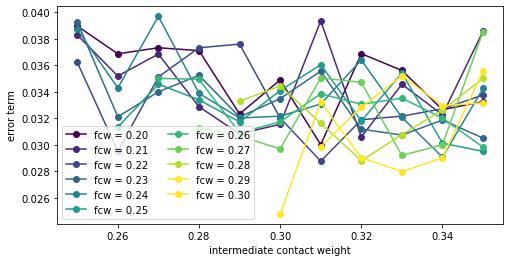

In [112]:
agg_results_selection_fine = agg_results_fine.copy().reset_index()

fig, ax = plt.subplots(figsize=(8,4))
cmap = plt.get_cmap('viridis')

for i, far_level in enumerate(far_contact_weights_fine):
    far_level = round(far_level, 2)
    agg_results_level = agg_results_selection_fine[\
        agg_results_selection_fine['far_contact_weight'] == far_level]\
        .reset_index(drop=True)

    popt, pcov = curve_fit(func, 
            agg_results_level['intermediate_contact_weight'],
            agg_results_level['chi2_distance_total_weighted'])
    
    ax.plot(agg_results_level['intermediate_contact_weight'],
            agg_results_level['chi2_distance_total_weighted'],
            'o-', color=cmap(i/(len(far_contact_weights_fine) - 2)),
            label='fcw = {:1.2f}'.format(far_level))
    
    #x = np.arange(0, 1.01, 0.01)
    #ax.plot(x, func(x, *popt),
    #        color=cmap(i/(len(far_contact_weights_coarse[0:-8]) - 2)))
    
ax.set_ylabel('error term')
ax.set_xlabel('intermediate contact weight')
ax.legend(ncol=2, loc=0);

## Coarse sampling with age dependence

### Create calibration parameter grid

In [7]:
## grid of parameters that need to be calibrated

N_runs = 500

# school types over which the calibration us run
school_types = ['primary', 'primary_dc', 'lower_secondary',
                'lower_secondary_dc', 'upper_secondary', 'secondary']

# the contact weight is the modifier by which the base transmission risk (for
# household transmissions) is multiplied for contacts of type "intermediate" 
# and of type "far"
intermediate_contact_weights = np.arange(0, 1, 0.05)
far_contact_weights = np.arange(0, 1, 0.05)

# the age_transmission_discount sets the slope of the age-dependence of the 
# transmission risk. Transmission risk for adults (age 18+) is always base 
# transmission risk. For every year an agent is younger than 18 years, the
# transmission risk is reduced
age_transmission_discounts = np.arange(-0.1, 0, 0.02)

# list of all possible parameter combinations from the grid
param_list = [(N_runs, i, j, k, l) for i in school_types \
                    for j in intermediate_contact_weights \
                    for k in far_contact_weights\
                    for l in age_transmission_discounts if j > k]

### Run the sampling

In [5]:
def run(param_list):
    '''
    Runs an ensemble of simulations and collects observable statistics. To be 
    run in parallel on many workers. Note: I/O paths and the number of runs per 
    ensemble hare hard coded here, because I only want to pass the parameter 
    values that are being screened in the simulation run to the function via the
    parallel processing interface.
    
    Parameters:
    -----------
    param_list : iterable
        Iterable that contains the values for the parameters test_type, 
        index_case, e_screen_range and r_screen_range that are passed to the
        simulation.
        
    Returns:
    --------
    row : dictionary
        Dictionary of the ensemble statistics of the observables.
    '''    

    # extract the simulation parameters from the parameter list
    N_runs, school_types, intermediate_contact_weight, far_contact_weight,\
            age_transmission_discount = params[sample_index]

    # run the ensemble with the given simulation parameters 
    ensemble_results = dcf.run_ensemble(N_runs, measures, simulation_params,
                contact_network_src, ensmbl_dst, index_case=index_case)

    # calculate the ensemble statistics
    row = dcf.evaluate_ensemble(ensemble_results, index_case)
    
    
        
        # run the ensemble with the given parameter combination and school type
        ensemble_results = cf.run_ensemble(N_runs, school_type,
                  intermediate_contact_weight, far_contact_weight, 
                  age_transmission_discount, prevention_measures,
                  school_characteristics, agent_index_ratios,
                  simulation_params, contact_network_src)

        # calculate the difference between the ensemble characteristics
        # (outbreak distribution, ratio of student to teacher cases)
        row = cf.evaluate_ensemble(ensemble_results, school_type,
                  intermediate_contact_weight, far_contact_weight,
                  age_transmission_discount, outbreak_sizes,
                  group_distributions)

    return row

In [8]:
# paths for data I/O
contact_network_src = '../../data/contact_networks/calibration'
dst = '../../data/calibration/simulation_results'

# number of runs per ensemble
# Note: this is set to 1 for testing purposes. To get properly converged 
# statistics, this has to be >= 500. Running such a high number of simulations
# will take a long time if run on just a single core. Therefore I strongly
# recommend to run the below code on several cores at once. It is easy to
# parallelize as each ensemble can be run on a different core and there are
# no interdependencies between ensembles. Results can be collected afterwards
# and evaulated together.
N_runs = 1

# progress bar
f = IntProgress(min=0, max=len(school_types) * len(samples)) 
display(f)
c = 0

results = pd.DataFrame()
for school_type in school_types:
    for sample_index in samples:
        # get the randomly sampled parameter combination
        intermediate_contact_weight, far_contact_weight,\
            age_transmission_discount = params[sample_index]
        
        # run the ensemble with the given parameter combination and school type
        ensemble_results = cf.run_ensemble(N_runs, school_type,
                  intermediate_contact_weight, far_contact_weight, 
                  age_transmission_discount, prevention_measures,
                  school_characteristics, agent_index_ratios,
                  simulation_params, contact_network_src)

        # calculate the difference between the ensemble characteristics
        # (outbreak distribution, ratio of student to teacher cases)
        row = cf.evaluate_ensemble(ensemble_results, school_type,
                  intermediate_contact_weight, far_contact_weight,
                  age_transmission_discount, outbreak_sizes,
                  group_distributions)

        results = results.append(row, ignore_index=True)
        
        f.value = c # update the progress bar
        c += 1 # update progress bar

results.reset_index()
index_cols = ['school_type', 'intermediate_contact_weight',
              'far_contact_weight', 'age_transmission_discount']
other_cols = [c for c in results.columns if c not in index_cols]
results = results[index_cols + other_cols]

results.to_csv(join(dst, 'calibration_results_coarse.csv'), index=False)

IntProgress(value=0, max=60)

### Analyze the random sampling

In [21]:
# load the collected ensemble statistics
dst = '../../data/calibration/simulation_results'
results = pd.read_csv(join(dst, 'calibration_results_random_sampling.csv'))
results.head(3)

,age_transmission_discount,chi2_distance_distro,chi2_distance_size,chi2_distance_total,far_contact_weight,intermediate_contact_weight,school_type,sum_of_squares_distro,sum_of_squares_size,sum_of_squares_total
0,-0.02,0.090392,0.080200,0.170592,0.15,0.45,primary,0.133439,0.101209,0.234648
1,-0.02,0.061329,0.007015,0.068345,0.70,0.95,primary,0.090537,0.007860,0.098396
2,-0.04,0.078039,0.046071,0.124110,0.10,0.85,primary,0.115204,0.057563,0.172767


In [22]:
# note: these are the number of clusters per school type from the slightly older
# data version (November 2020). For primary and lower secondary school types,
# the counts are split evenly between schools with and without daycare. 
counts = pd.DataFrame({'type':['primary', 'primary_dc', 
                               'lower_secondary', 'lower_secondary_dc',
                               'upper_secondary', 'secondary'],
                      'count':[33.5, 33.5, 90, 90, 116, 70]})

counts.index = counts['type']
counts = counts.drop(columns=['type'])

# The cluster counts are used to weigh the respective school type in the 
# calibration process.
counts['weight'] = counts['count'] / counts['count'].sum()
results['chi2_distance_total_weighted'] = results['chi2_distance_total']
weights = []
for i, row in results.iterrows():
    st = row['school_type']
    weight = counts.loc[st, 'weight']
    error = row['chi2_distance_total']
    results.loc[i, 'chi2_distance_total_weighted'] = error * weight

In [23]:
# since we calibrate the intermediate_contact_weight, far_contact_weight and 
# age_transmission_discount over all school types together, we have to find
# the parameter combination that minimizes the sum of errors over all school
# types. 
agg_results = results.groupby(['intermediate_contact_weight',
                               'far_contact_weight',
                               'age_transmission_discount']).sum()

opt = agg_results.loc[agg_results['chi2_distance_total_weighted'].idxmin()].name
opt_intermediate_contact_weight = opt[0]
opt_far_contact_weight = opt[1]
opt_age_transmission_discount = opt[2]

print('optimal random sampling parameter combination:')
print('\t intermediate contact weight: {:1.3f}'.format(opt_intermediate_contact_weight))
print('\t far contact weight: {:1.3f}'.format(opt_far_contact_weight))
print('\t age transmission discount: {:1.3f}'.format(opt_age_transmission_discount))

optimal random sampling parameter combination:
	 intermediate contact weight: 0.850
	 far contact weight: 0.750
	 age transmission discount: -0.020


## Grid search

### Create calibration parameter grid

In [51]:
## grid of parameters that need to be calibrated
# the contact weight is the modifier by which the base transmission risk (for
# household transmissions) is multiplied for contacts of type "intermediate" 
# and of type "far". Parameter values are chosen around the optimum from the
# previous random sampling search
intermediate_contact_weights = [0.825, 0.875]
far_contact_weights = [0.725, 0.75]

# the age_transmission_discount sets the slope of the age-dependence of the 
# transmission risk. Transmission risk for adults (age 18+) is always base 
# transmission risk. For every year an agent is younger than 18 years, the
# transmission risk is reduced. Parameter values are chosen around the optimum 
# from the previous random sampling search
age_transmission_discounts = [-0.015,-0.0175,-0.0225,-0.025,-0.0275]

# list of all possible parameter combinations from the grid
params = [(i, j, k) for i in intermediate_contact_weights \
                    for j in far_contact_weights\
                    for k in age_transmission_discounts if i > j]

### Run the sampling

In [52]:
# paths for data I/O
contact_network_src = '../../data/contact_networks/calibration'
dst = '../../data/calibration/simulation_results'

school_types = ['primary', 'primary_dc', 'lower_secondary',
                'lower_secondary_dc', 'upper_secondary', 'secondary']

# number of runs per ensemble
# Note: this is set to 1 for testing purposes. To get properly converged 
# statistics, this has to be >= 500. Running such a high number of simulations
# will take a long time if run on just a single core. Therefore I strongly
# recommend to run the below code on several cores at once. It is easy to
# parallelize as each ensemble can be run on a different core and there are
# no interdependencies between ensembles. Results can be collected afterwards
# and evaulated together.
N_runs = 1

# progress bar
f = IntProgress(min=0, max=len(school_types) * len(params)) 
display(f)
c = 0

results = pd.DataFrame()
for school_type in school_types:
    for p in params:
        # get the randomly sampled parameter combination
        intermediate_contact_weight, far_contact_weight,\
            age_transmission_discount = p
        
        # run the ensemble with the given parameter combination and school type
        ensemble_results = cf.run_ensemble(N_runs, school_type,
                  intermediate_contact_weight, far_contact_weight, 
                  age_transmission_discount, prevention_measures,
                  school_characteristics, agent_index_ratios,
                  simulation_params, contact_network_src)

        # calculate the difference between the ensemble characteristics
        # (outbreak distribution, ratio of student to teacher cases)
        row = cf.evaluate_ensemble(ensemble_results, school_type,
                  intermediate_contact_weight, far_contact_weight,
                  age_transmission_discount, outbreak_sizes,
                  group_distributions)

        results = results.append(row, ignore_index=True)
        
        f.value = c
        c += 1 # update progress bar

results.reset_index()
index_cols = ['school_type', 'intermediate_contact_weight',
              'far_contact_weight', 'age_transmission_discount']
other_cols = [c for c in results.columns if c not in index_cols]
results = results[index_cols + other_cols]

# combine the results from the random sampling with the grid results
#random_results = pd.read_csv(join(dst, 'calibration_results_random_sampling.csv'))
#results = pd.concat([random_results, results])
#results.to_csv(join(dst, 'calibration_results_grid_search.csv'), index=False)

IntProgress(value=0, max=120)

### Analyze the grid search

In [46]:
# load the collected ensemble statistics
dst = '../../data/calibration/simulation_results'
grid_results = pd.read_csv(join(dst, 'calibration_results_grid_search.csv'))
grid_results.head(3)

,age_transmission_discount,chi2_distance_distro,chi2_distance_size,chi2_distance_total,far_contact_weight,intermediate_contact_weight,school_type,sum_of_squares_distro,sum_of_squares_size,sum_of_squares_total
0,-0.02,0.090392,0.080200,0.170592,0.15,0.45,primary,0.133439,0.101209,0.234648
1,-0.02,0.061329,0.007015,0.068345,0.70,0.95,primary,0.090537,0.007860,0.098396
2,-0.04,0.078039,0.046071,0.124110,0.10,0.85,primary,0.115204,0.057563,0.172767


In [47]:
counts = pd.DataFrame({'type':['primary', 'primary_dc', 
                               'lower_secondary', 'lower_secondary_dc',
                               'upper_secondary', 'secondary'],
                      'count':[33.5, 33.5, 90, 90, 116, 70]})
counts.index = counts['type']
counts = counts.drop(columns=['type'])
counts['weight'] = counts['count'] / counts['count'].sum()
grid_results['chi2_distance_total_weighted'] = grid_results['chi2_distance_total']
weights = []
for i, row in grid_results.iterrows():
    st = row['school_type']
    weight = counts.loc[st, 'weight']
    error = row['chi2_distance_total']
    grid_results.loc[i, 'chi2_distance_total_weighted'] = error * weight

In [49]:
agg_results = grid_results.groupby(['age_transmission_discount', 'intermediate_contact_weight',
                 'far_contact_weight']).sum()
opt = agg_results.loc[agg_results['chi2_distance_total_weighted'].idxmin()].name
opt_intermediate_contact_weight = opt[0]
opt_far_contact_weight = opt[1]
opt_age_transmission_discount = opt[2]

print('optimal grid search parameter combination:')
print('\t intermediate contact weight: {:1.3f}'.format(opt_intermediate_contact_weight))
print('\t far contact weight: {:1.3f}'.format(opt_far_contact_weight))
print('\t age transmission discount: {:1.3f}'.format(opt_age_transmission_discount))

optimal grid search parameter combination:
	 intermediate contact weight: -0.020
	 far contact weight: 0.850
	 age transmission discount: 0.750
